# Transformers-based Classification (Single Label)

This notebook implements transformer-based models to classify research papers into categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from ast import literal_eval
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy

## Data Loading & Preprocessing


In [2]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_single_label_2025.csv")
df_existing.head(2)

,title,abstract,link,authors,category
0,A Framework to Generate Neurosymbolic PDDL-com...,Symbolic task planning is a widely used approa...,https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",['plan-generation']
1,A Prefrontal Cortex-inspired Architecture for ...,Large language models (LLMs) demonstrate impre...,https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",['brain-inspired-planning']


In [3]:
def standardize_single_category(category):
    """Normalize category strings by removing list artifacts and enforcing a slug."""
    if pd.isna(category):
        return None
    value = category
    if isinstance(value, str):
        stripped = value.strip()
        if stripped.startswith("[") and stripped.endswith("]"):
            try:
                parsed = literal_eval(stripped)
                if isinstance(parsed, list) and parsed:
                    value = parsed[0]
                else:
                    value = ""
            except (ValueError, SyntaxError):
                value = stripped.strip("[]")
        else:
            value = stripped
    if isinstance(value, list):
        value = value[0] if value else ""
    value = str(value).strip().strip("'\"")
    if not value:
        return None
    return value.lower().replace(" ", "-")

# Clean category labels before filtering rare classes
df_existing["category"] = df_existing["category"].apply(standardize_single_category)
df_existing.dropna(subset=["category"], inplace=True)
df_existing.reset_index(drop=True, inplace=True)

# Identify and remove categories with only one sample
value_counts = df_existing["category"].value_counts()
to_remove = value_counts[value_counts == 1].index

if len(to_remove) > 0:
    print(f"Removing {len(to_remove)} categories with only one sample: {list(to_remove)}")
    df_existing = df_existing[~df_existing["category"].isin(to_remove)]
    df_existing.reset_index(drop=True, inplace=True)
    print(f"New shape of df_existing: {df_existing.shape}")
else:
    print("No categories with only one sample found.")

Removing 1 categories with only one sample: ['replanning']
New shape of df_existing: (166, 5)


In [4]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/new_arxiv_papers_20251025_120307.csv")
df_new.head(2)

,Title,Authors,Published Date,Abstract,URL,Categories
0,Using Large Language Models for Abstraction of...,"Bita Banihashemi, Megh Patel, Yves Lespérance",2025-10-23,Generating an abstraction of a dynamic domain ...,http://arxiv.org/abs/2510.20258v1,"cs.AI, I.2"
1,A Systematic Study of Large Language Models fo...,Jorge Mendez-Mendez,2025-09-30,Using large language models (LLMs) to solve co...,http://arxiv.org/abs/2510.00182v1,"cs.RO, cs.AI"


In [5]:
if "Categories" in df_new.columns:
    df_new["Categories"] = df_new["Categories"].apply(standardize_single_category)

In [6]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [7]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_existing = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [8]:
X_existing_array = X_existing.toarray()

In [9]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

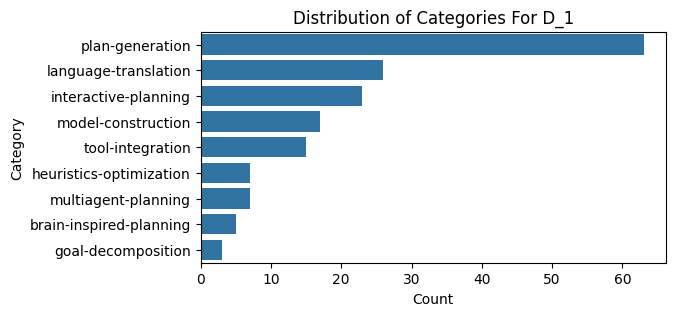

In [10]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_1")

<br>


## Create Features


In [11]:
# Initialize label encoder
le = LabelEncoder()
y_old = le.fit_transform(df_existing["category"])

In [12]:
# Use StratifiedShuffleSplit for single-label classification
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

train_idx, test_idx = next(sss.split(X_existing_array, y_old))

df_train = df_existing.iloc[train_idx].copy()
df_test = df_existing.iloc[test_idx].copy()

X_train = X_existing[train_idx]
X_test = X_existing[test_idx]

y_train = y_old[train_idx]
y_test = y_old[test_idx]

In [13]:
print(f"Training set shape: {df_train.shape}, TF-IDF matrix: {X_train.shape}")
print(f"Test set shape: {df_test.shape}, TF-IDF matrix: {X_test.shape}")

Training set shape: (132, 6), TF-IDF matrix: (132, 3370)
Test set shape: (34, 6), TF-IDF matrix: (34, 3370)


In [14]:
def print_label_distribution(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    label_counts = dict(zip(unique, counts))
    print(f"\nLabel distribution in {set_name}:")
    for label_idx, count in label_counts.items():
        print(f"{le.inverse_transform([label_idx])[0]}: {count}")


print_label_distribution(y_train, "training set")
print_label_distribution(y_test, "test set")


Label distribution in training set:
brain-inspired-planning: 4
goal-decomposition: 2
heuristics-optimization: 6
interactive-planning: 18
language-translation: 21
model-construction: 13
multiagent-planning: 6
plan-generation: 50
tool-integration: 12

Label distribution in test set:
brain-inspired-planning: 1
goal-decomposition: 1
heuristics-optimization: 1
interactive-planning: 5
language-translation: 5
model-construction: 4
multiagent-planning: 1
plan-generation: 13
tool-integration: 3


## Train, Evaluate, and Test Model


In [15]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is a false-y value or not supplied, disables deterministic mode."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed = 13
set_seed(seed)

In [16]:
class PaperDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

In [17]:
class TransformerClassifier:
    def __init__(
        self,
        model_name,
        num_labels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.base_model = AutoModel.from_pretrained(model_name).to(device)

        # Freeze the transformer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Modified classifier for single-label classification
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.base_model.config.hidden_size, num_labels),
            torch.nn.LogSoftmax(dim=1),
        ).to(device)

    def get_embeddings(self, texts, batch_size=8):
        # Ensure texts are in a list of strings
        if isinstance(texts, pd.Series):
            texts = texts.tolist()

        dataset = PaperDataset(texts, self.tokenizer)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []

        self.base_model.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Getting embeddings"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)

                outputs = self.base_model(
                    input_ids=input_ids, attention_mask=attention_mask
                )

                # Use [CLS] token embedding
                embeddings = outputs.last_hidden_state[:, 0, :]
                all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

    def fit(
        self, train_texts, train_labels, epochs=3, batch_size=8, learning_rate=1e-3
    ):
        train_embeddings = self.get_embeddings(train_texts, batch_size=batch_size)
        train_labels = torch.tensor(train_labels).long()

        train_dataset = torch.utils.data.TensorDataset(train_embeddings, train_labels)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=learning_rate)
        loss_fn = torch.nn.NLLLoss()

        self.classifier.train()
        for epoch in range(epochs):
            for embeddings, labels in tqdm(
                train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
            ):
                embeddings, labels = embeddings.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                logits = self.classifier(embeddings)
                loss = loss_fn(logits, labels)
                loss.backward()
                optimizer.step()

    def predict(self, texts, batch_size=8):
        embeddings = self.get_embeddings(texts, batch_size=batch_size)
        self.classifier.eval()
        with torch.no_grad():
            logits = self.classifier(embeddings.to(self.device))
            predictions = torch.argmax(logits, dim=1)
        return predictions.cpu().numpy()

In [18]:
def evaluate_models(df_train, y_train, df_test, y_test, df_new, le):
    model_configs = {
        "BERT": "bert-base-uncased",
        "SciBERT": "allenai/scibert_scivocab_uncased",
    }

    results = {}

    for model_name, model_path in model_configs.items():
        print(f"\nEvaluating {model_name}...")

        # Initialize and train classifier
        classifier = TransformerClassifier(model_path, num_labels=len(le.classes_))
        classifier.fit(df_train["text"], y_train)

        # Get predictions for test set
        y_pred_test = classifier.predict(df_test["text"])

        # Get predictions for new data
        y_pred_new = classifier.predict(df_new["text"])

        # Convert numeric predictions back to category labels
        y_pred_test_labels = le.inverse_transform(y_pred_test)
        y_pred_new_labels = le.inverse_transform(y_pred_new)

        results[model_name] = {
            "test_report": classification_report(
                le.inverse_transform(y_test), y_pred_test_labels, zero_division=0
            ),
            "predictions": y_pred_new_labels,
        }

        # Store predictions in dataframe
        df_new[f"{model_name}_predicted"] = y_pred_new_labels

    return results

In [19]:
# Now evaluate the models using the test set we created earlier
results = evaluate_models(df_train, y_train, df_test, y_test, df_new, le)


Evaluating BERT...


/Users/nitingupta/miniconda3/envs/aiisc_litcat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████| 7/7 [00:33<00:00,  4.78s/it]




Evaluating SciBERT...


/Users/nitingupta/miniconda3/envs/aiisc_litcat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████| 7/7 [00:28<00:00,  4.06s/it]



In [20]:
# Print results for the test dataset
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(model_data["test_report"])


Results for BERT on test set:
                         precision    recall  f1-score   support

brain-inspired-planning       0.00      0.00      0.00         1
     goal-decomposition       0.00      0.00      0.00         1
heuristics-optimization       0.00      0.00      0.00         1
   interactive-planning       0.00      0.00      0.00         5
   language-translation       0.00      0.00      0.00         5
     model-construction       0.00      0.00      0.00         4
    multiagent-planning       0.00      0.00      0.00         1
        plan-generation       0.36      0.92      0.52        13
       tool-integration       0.00      0.00      0.00         3

               accuracy                           0.35        34
              macro avg       0.04      0.10      0.06        34
           weighted avg       0.14      0.35      0.20        34


Results for SciBERT on test set:
                         precision    recall  f1-score   support

brain-inspired-planni

In [21]:
# Convert predictions back to categories for all classifiers
for classifier, data in results.items():
    df_new[f"{classifier}_predicted"] = data["predictions"]
    print(f"\nPredicted category distribution for {classifier}:")
    print(df_new[f"{classifier}_predicted"].value_counts())


Predicted category distribution for BERT:
BERT_predicted
plan-generation         48
language-translation     1
Name: count, dtype: int64

Predicted category distribution for SciBERT:
SciBERT_predicted
plan-generation         32
interactive-planning    10
language-translation     7
Name: count, dtype: int64
BERT_predicted
plan-generation         48
language-translation     1
Name: count, dtype: int64

Predicted category distribution for SciBERT:
SciBERT_predicted
plan-generation         32
interactive-planning    10
language-translation     7
Name: count, dtype: int64


In [22]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'text', 'BERT_predicted', 'SciBERT_predicted'],
      dtype='object')

In [23]:
# Save results to a new CSV for predictions
df_new.to_csv("../outputs/tf_single_label_preds_2025.csv", index=False)